In [124]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import qutip as qt
from qutip import Bloch, about, basis, mesolve,sigmax, sigmay, sigmaz,identity,fidelity,expect,Options,sigmap,sigmam,phase_basis,Qobj
%matplotlib inline

# Plot spin evolution under perfect ramsy experiment
ref:
- http://www.phys.ufl.edu/~avinash/Notes/Ramsey_Tex/Notes.pdf
- http://home.ustc.edu.cn/~skyjoy/Two-level%20system.pdf
- Yutong's Journal Club Slide
- Atomic Physics C. J. FOOT

In [51]:
# operators and the hamiltonian
sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = sigmap()
sm = sigmam()
I = identity(2)

# Schrodinger Picture

In [52]:
def qubit_integrate_schrodinger(psi0, tlist ,w0,detuning,rabi_amp):
    w1 = w0-detuning*rabi_amp
    # evolve and calculate expectation values
    H0 = w0*sz/2
    H1 = rabi_amp*sx
    def H1_coeff(t,args):
        return np.cos(w1*t)
    H = [H0,[H1,H1_coeff]]
    output = mesolve(H, psi0, tlist,c_ops=[],e_ops=[sx,sy,sz],options = Options(store_final_state=True))
    return output

In [53]:
from matplotlib import animation
from base64 import b64encode
from IPython.display import HTML, Javascript, display
def plot_animation(plot_setup_func, plot_func, result_lst, name="movie",
                   writer="avconv", codec="libx264", verbose=False):
    """
    Create an animated plot of a Result object, as returned by one of
    the qutip evolution solvers.

    .. note :: experimental
    """

    fig, axes = plot_setup_func(result_lst)

    
    result = [[],[],[]]
    ntimes = 0
    for r in result_lst:
        resx = r.expect[0]
        resy = r.expect[1]
        resz = r.expect[2]
        for ind in range(len(r.times)):
            result[0].append(resx[ind])
            result[1].append(resy[ind])
            result[2].append(resz[ind])
        ntimes += len(r.times)
    def update(n):
        return plot_func(result, n, fig=fig, axes=axes)
    anim = animation.FuncAnimation(
        fig, update, frames= ntimes, blit=True)

    anim.save(name + '.mp4', fps=30, writer=writer, codec=codec)

    plt.close(fig)

    if verbose:
        print("Created %s.m4v" % name)

    video = open(name + '.mp4', "rb").read()
    video_encoded = b64encode(video).decode("ascii")
    video_tag = '<video controls src="data:video/x-m4v;base64,{0}">'.format(
        video_encoded)
    return HTML(video_tag)


def plot_setup(result):

    fig = plt.figure(figsize=(8, 8))
    axes = Axes3D(fig, azim=-40, elev=30)

    return fig, axes
sphere = None
def plot_result(result, n, fig=None, axes=None):
    
    global sphere

    if fig is None or axes is None:
        fig, axes = plot_setup(result)

    if not sphere:
        sphere = Bloch(axes=axes)
        sphere.vector_color = ["r"]

    sphere.clear()
    sphere.add_vectors([result[0][n],
                        result[1][n],
                        result[2][n]])
    sphere.add_points(
        [
            result[0][: n + 1],
            result[1][: n + 1],
            result[2][: n + 1],
        ],
        meth="l",
    )
    
    sphere.make_sphere()
    
    return axes.artists
# You can choose your own writer and codec here.
# Setting codec=None sets the codec to the standard
# defined in matplotlib.rcParams['animation.codec']
psi0 = basis(2, 0)
psi1 = basis(2, 1)
tau = 10
rabi_amp = np.pi*0.1
detuning = 0
w0 = np.pi*2
T = 2/(np.sqrt(1+detuning**2)*rabi_amp)*np.arcsin(np.sqrt((1+detuning**2)/2))   

t1list = np.linspace(0,T,100)
t2list = np.linspace(0,tau,100)
print(f"T:{T},tau:{tau}")
result1 =  qubit_integrate_schrodinger(psi0, t1list,w0,detuning,rabi_amp)
result2 =  qubit_integrate_schrodinger(result1.final_state, t2list,w0,detuning,0)
result3 =  qubit_integrate_schrodinger(result2.final_state, t1list,w0,detuning,rabi_amp)
print(f"|c_g|^2 of result 1:{expect(psi1*psi1.dag(),result1.final_state)},result 2:{expect(psi1*psi1.dag(),result2.final_state)},result 3:{expect(psi1*psi1.dag(),result3.final_state)}")
plot_animation(plot_setup, plot_result, [result1,result2,result3], writer="ffmpeg", codec=None)

T:5.000000000000001,tau:10
|c_g|^2 of result 1:0.49985764949327843,result 2:0.4998576494932778,result 3:0.9998427490556738


<Figure size 360x360 with 0 Axes>

# Interaction Picture
\begin{equation}
H= -\frac{\Delta}{2}\sigma_z  +\frac{\Omega}{2}e^{i\phi}\sigma_++\frac{\Omega}{2}e^{-i\phi}\sigma_-
\end{equation}

In [54]:
def qubit_integrate_inter(psi0, tlist,detuning,rabi_amp,phi):

    # evolve and calculate expectation values
    H0 = -detuning*sz*rabi_amp/2
    H1 = rabi_amp*sp*np.exp(1j*phi)/2
    H2 = rabi_amp*sm*np.exp(-1j*phi)/2
    H = [H0,H1,H2]
    output = mesolve(H, psi0, tlist,c_ops=[],e_ops=[sx,sy,sz],options = Options(store_final_state=True))
    return output

In [55]:
sphere = None
tau = 10
rabi_amp = np.pi*0.1
detuning = 0
T = 2/(np.sqrt(1+detuning**2)*rabi_amp)*np.arcsin(np.sqrt((1+detuning**2)/2))

t1list = np.linspace(0,T,100)
t2list = np.linspace(0,tau,100)
print(f"T:{T},tau:{tau}")
phi = 0
result1 =  qubit_integrate_inter(psi0, t1list,detuning,rabi_amp,phi)
result2 =  qubit_integrate_inter(result1.final_state, t2list,detuning,0,phi)
result3 =  qubit_integrate_inter(result2.final_state, t1list,detuning,rabi_amp,phi)
plot_animation(plot_setup, plot_result, [result1,result2,result3], writer="ffmpeg", codec=None)

T:5.000000000000001,tau:10


<Figure size 360x360 with 0 Axes>

# Ramsey signal

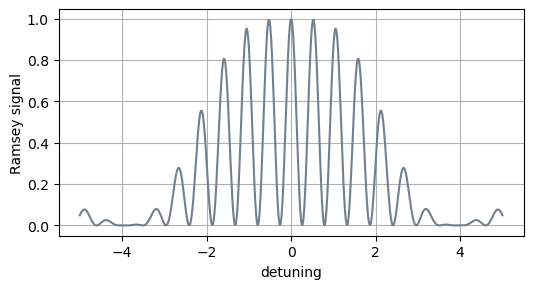

In [116]:
psi1 = basis(2,1)
#define hamiltonian
def qubit_integrate_inter(psi0, tlist,detuning,rabi_amp,phi):

    # evolve and calculate expectation values
    H0 = -detuning*sz/2
    H1 = rabi_amp*sp*np.exp(1j*phi)/2
    H2 = rabi_amp*sm*np.exp(-1j*phi)/2
    H = [H0,H1+H2]
    output = mesolve(H, psi0, tlist,c_ops=[],e_ops=[sx,sy,sz],options = Options(store_final_state=True))
    return output

# Define a Ramsey experiment.
def ramsey(tau,rabi_amp,detuning,phi):
    T = 2/(rabi_amp)*np.arcsin(np.sqrt(1/2))
    t1list = np.linspace(0,T,100)
    t2list = np.linspace(0,tau,100)
    # pi/2 Pulse
    result1 =  qubit_integrate_inter(psi0, t1list,detuning,rabi_amp,phi)
    # Free decay
    if tau==0:
        result2 = result1
    else:
        result2 = qubit_integrate_inter(result1.final_state,t2list,detuning,0,phi)
    # pi/2 Pulse
    state = result2.final_state
    result3 =  qubit_integrate_inter(state, t1list,detuning,rabi_amp,phi)
    final_state = result3.final_state
    return expect(psi1*psi1.dag(),final_state)


phi  = 0
num_samples = 500
rabi_amp = 1
idle_tlist = np.linspace(0., 100., num_samples)
detuning_tlist = np.linspace(-5,5, num_samples)
# measurements = np.asarray([ramsey(t,rabi_amp,detuning,phi,t2) for t in idle_tlist])
measurements = np.asarray([ramsey(10,rabi_amp,detuning,phi) for detuning in detuning_tlist])
fig, ax = plt.subplots(figsize = (6, 3), dpi=100)
# ax.plot(idle_tlist[:], measurements[:], '-', label="Simulation", color="slategray")
ax.plot(detuning_tlist[:], measurements[:], '-', label="Simulation", color="slategray")
# ax.plot(idle_tlist, decay_func(idle_tlist, t2_fit, f0_fit), '--', label="Theory", color="slategray")
# ax.set_xlabel(r"Idling time $t$ [$\mu$s]")
ax.set_xlabel(r"detuning")
ax.set_ylabel("Ramsey signal", labelpad=2)
ax.set_ylim((ax.get_ylim()[0], ax.get_ylim()[1]))
ax.grid()

# random phase shift

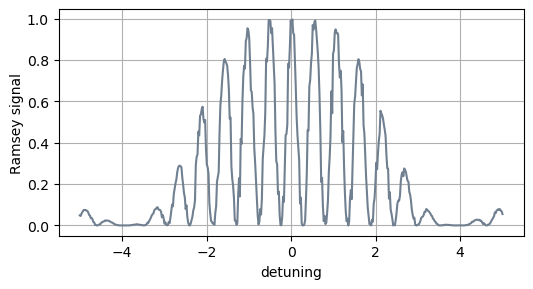

In [217]:
# Define a Ramsey experiment.


def ramsey_with_random_phase(tau,rabi_amp,detuning,phi):
    T = 2/(rabi_amp)*np.arcsin(np.sqrt(1/2))
    t1list = np.linspace(0,T,100)
    t2list = np.linspace(0,tau,100)
    # pi/2 Pulse
    result1 =  qubit_integrate_inter(psi0, t1list,detuning,rabi_amp,phi)
    # Free decay
    if tau==0:
        result2 = result1
    else:
        result2 = qubit_integrate_inter(result1.final_state,t2list,detuning,0,phi)
    # pi/2 Pulse
    phase = np.random.uniform(0,np.pi/6)
    state = Qobj([[1,0],[0,np.exp(1j*phase)]])*result2.final_state
    result3 =  qubit_integrate_inter(state, t1list,detuning,rabi_amp,phi)
    final_state = result3.final_state
    return expect(psi1*psi1.dag(),final_state)
phi  = 0
num_samples = 500
rabi_amp = 1
idle_tlist = np.linspace(0., 100., num_samples)
detuning_tlist = np.linspace(-5,5, num_samples)
# measurements = np.asarray([ramsey(t,rabi_amp,detuning,phi,t2) for t in idle_tlist])
measurements = np.asarray([ramsey_with_random_phase(10,rabi_amp,detuning,phi) for detuning in detuning_tlist])
fig, ax = plt.subplots(figsize = (6, 3), dpi=100)
# ax.plot(idle_tlist[:], measurements[:], '-', label="Simulation", color="slategray")
ax.plot(detuning_tlist[:], measurements[:], '-', label="Simulation", color="slategray")
# ax.plot(idle_tlist, decay_func(idle_tlist, t2_fit, f0_fit), '--', label="Theory", color="slategray")
# ax.set_xlabel(r"Idling time $t$ [$\mu$s]")
ax.set_xlabel(r"detuning")
ax.set_ylabel("Ramsey signal", labelpad=2)
ax.set_ylim((ax.get_ylim()[0], ax.get_ylim()[1]))
ax.grid()

# measure T2 (relaxtion time)
ref:
[1]https://qudev.phys.ethz.ch/static/content/courses/QSIT11/QSIT11_V08_slides.pdf 
[2]https://qudev.phys.ethz.ch/static/content/science/Documents/phd/PhD-Romeo_Bianchetti.pdf
about T1 and T2

T2 measurements using Ramsey oscillations

The preservation of the excitation during the operation is not enough for quantum information tasks, but the qubit phase plays a central role [Childs10].In general, one can identify two contributions to the phase decoherence rate
$\gamma_2 = 1/T_2$: the decoherence related to the energy decay rate$\gamma_1$and an additional decoherence rate arising from slow (on the timescale $1/\omega_0$) fluctuations of the qubit transition frequency, called pure dephasing $\gamma_\phi$ [Nielsen00]. The
dephasing time T2 describes the timescale at which the off diagonal terms of the qubits density matrix decay and is usually defined as
\begin{equation}
\rho_{01} = e^{i\omega_0t}e^{-t/T_2}
\end{equation}

For a single qubit state, these effects may be phenomenologically characterized
with a density matrix transformation model,

\begin{equation}
\left[\begin{array}{cc}
a & b \\
b^* & 1-a
\end{array}\right] \rightarrow\left[\begin{array}{cc}
\left(a-a_0\right) e^{-t / T_1}+a_0 & b e^{-t / T_2} \\
b^* e^{-t / T_2} & \left(a_0-a\right) e^{-t / T_1}+1-a_0
\end{array}\right]
\end{equation}

where T1 and T2 are known as the spin–lattice (or ‘longitudinal’) and spin–spin (or‘transverse’) relaxation rates, respectively, and a0 characterizes the thermal equilibrium state.

T2: 10
Fitted T2: 12.540631996200476


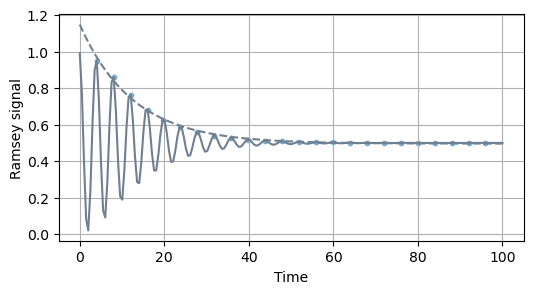

In [206]:
from scipy import signal,optimize
psi1 = basis(2,1)
#define hamiltonian
def qubit_integrate_inter(psi0, tlist,detuning,rabi_amp,phi):
    # evolve and calculate expectation values
    H0 = -detuning*sz/2
    H1 = rabi_amp*sp*np.exp(1j*phi)/2
    H2 = rabi_amp*sm*np.exp(-1j*phi)/2
    H = [H0+H1+H2]
    output = mesolve(H, psi0, tlist,c_ops=[],e_ops=[sx,sy,sz],options = Options(store_final_state=True))
    return output

# Define a Ramsey experiment.
def ramsey(tau,rabi_amp,detuning,phi,T2):
#     T = 2/(rabi_amp)*np.arcsin(np.sqrt(1/2))
    T = 2/(np.sqrt(rabi_amp**2+detuning**2))*np.arcsin(np.sqrt((rabi_amp**2+detuning**2)/(2*rabi_amp**2)))
    t1list = np.linspace(0,T,100)
    t2list = np.linspace(0,tau,100)
    # pi/2 Pulse
    result1 =  qubit_integrate_inter(psi0, t1list,detuning,rabi_amp,phi)
    # Free decay
    if tau==0 or detuning==0:
        result2 = result1
    else:
        result2 = qubit_integrate_inter(result1.final_state,t2list,detuning,0,phi)
    state = Qobj([[1,0],[0,np.exp(-tau/T2)]])*result2.final_state
    # pi/2 Pulse
    result3 =  qubit_integrate_inter(state, t1list,detuning,rabi_amp,phi)
    final_state = result3.final_state
    return expect(psi1*psi1.dag(),final_state)


phi  = 0
num_samples = 200
rabi_amp = np.pi*5
idle_tlist = np.linspace(0.,100., num_samples)
detuning = 0.1*rabi_amp
t2 = 10
measurements = np.asarray([ramsey(t,rabi_amp,detuning,phi,t2) for t in idle_tlist])

fig, ax = plt.subplots(figsize = (6, 3), dpi=100)
ax.plot(idle_tlist[:], measurements[:], '-', label="Simulation", color="slategray")

peak_ind = signal.find_peaks(measurements)[0]
def decay_func(t,t2,f0,f1):
    return f0 * np.exp(-t/t2)+f1

(t2_fit, f0_fit,f1_fit), _ = optimize.curve_fit(decay_func, idle_tlist[peak_ind], measurements[peak_ind])

print("T2:", t2)
print("Fitted T2:", t2_fit)
ax.scatter(idle_tlist[peak_ind], measurements[peak_ind],s=10,alpha=0.5)
ax.plot(idle_tlist, decay_func(idle_tlist, t2_fit, f0_fit,f1_fit), '--', label="Theory", color="slategray")
ax.set_xlabel(r"Time")
ax.set_ylabel("Ramsey signal", labelpad=2)
ax.set_ylim((ax.get_ylim()[0], ax.get_ylim()[1]))
ax.grid()

# Spin echo
ref:https://qudev.phys.ethz.ch/static/content/science/Documents/semester/Steffen_Lars_SemesterThesis_070427_SpinEchoesv2.0.pdf

In [223]:
def qubit_integrate_inter(psi0, tlist,detuning,rabi_amp,phi):

    # evolve and calculate expectation values
    H0 = -detuning*sz/2
    H1 = rabi_amp*sx/2
    H = [H0,H1]
    output = mesolve(H, psi0, tlist,c_ops=[],e_ops=[sx,sy,sz],options = Options(store_final_state=True))
    return output
def qubit_decay(psi0,tlist):
    np.random.seed(0)
    phase = np.random.uniform(0,np.pi/6)
    H =  Qobj([[1,0],[0,phase]])
    output = mesolve(H, psi0, tlist,c_ops=[],e_ops=[sx,sy,sz],options = Options(store_final_state=True))
    return output
sphere = None
tau = 2
rabi_amp = np.pi*0.1
detuning = 0
T1 = 2/(rabi_amp)*np.arcsin(np.sqrt(1/2))
T2 = 2/(rabi_amp)*np.arcsin(np.sqrt(1/1))
t1list = np.linspace(0,T1,100)
t2list = np.linspace(0,T2,100)
t3list = np.linspace(0,tau,100)
print(f"T1:{T1},T2:{T2}")
phi = 0
result1 =  qubit_integrate_inter(psi0, t1list,detuning,rabi_amp,phi)
result2 = qubit_decay(result1.final_state,t3list)
result3 =  qubit_integrate_inter(result2.final_state, t2list,detuning,rabi_amp,phi)
result4 = qubit_decay(result3.final_state,t3list)
result5 =  qubit_integrate_inter(result4.final_state, t1list,detuning,rabi_amp,phi)
plot_animation(plot_setup, plot_result, [result1,result2,result3,result4,result5], writer="ffmpeg", codec=None)

T1:5.000000000000001,T2:10.0


<Figure size 360x360 with 0 Axes>